In [56]:
import fastf1
import os
from fastf1 import plotting
from fastf1.core import Laps
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import logging
from __future__ import annotations
from typing import List, Optional
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Desativar avisos
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [35]:
# Limpa o cache do FastF1 e cria um novo diretório de cache
cache_dir = './fastf1_cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
    print(f"Diretório de cache '{cache_dir}' criado.")

fastf1.Cache.clear_cache(cache_dir) 
print(f"Cache do FastF1 em '{cache_dir}' limpo.")

fastf1.Cache.enable_cache(cache_dir)

Cache do FastF1 em './fastf1_cache' limpo.


In [39]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

CACHE_DIR = "./fastf1_cache"
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
    logger.info("Diretório de cache '%s' criado.", CACHE_DIR)

fastf1.Cache.clear_cache(CACHE_DIR)
fastf1.Cache.enable_cache(CACHE_DIR)
logger.info("Cache '%s' limpo e habilitado.", CACHE_DIR)

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

def generate_main_dataset(year=2024, event='British Grand Prix', cache_dir='./fastf1_cache', driver_filter=None, years_filter=None):
    fastf1.Cache.enable_cache(cache_dir)

    try:
        session = fastf1.get_session(year, event, 'R')
        print(f"🔄 Carregando sessão: {event} {year} - Corrida (R)…")
        session.load(telemetry=True, weather=True)
    except Exception as e:
        print(f"❌ Erro ao carregar sessão: {e}")
        return pd.DataFrame()

    full_data = []

    # Processar dados meteorológicos
    weather_data = session.weather_data
    if not weather_data.empty:
        weather_data['Time'] = weather_data['Time'].dt.round('s')
        weather_data_agg = weather_data.resample('1min', on='Time').mean().reset_index()
    else:
        weather_data_agg = pd.DataFrame()

    for driver in session.drivers:
        if driver_filter and driver != driver_filter:
            continue

        laps = session.laps.pick_driver(driver).pick_quicklaps()
        if laps.empty:
            continue

        laps = laps.sort_values(by='LapNumber').reset_index(drop=True)
        laps['stint_id'] = laps['Stint']
        laps['s_lap'] = laps.groupby('stint_id').cumcount() + 1
        laps['s_total'] = laps.groupby('stint_id')['LapNumber'].transform('count')
        laps['s_pct'] = laps['s_lap'] / laps['s_total']
        laps['best_s_lap'] = laps.groupby('stint_id')['LapTime'].transform('min').dt.total_seconds()
        laps['delta_best'] = laps['LapTime'].dt.total_seconds() - laps['best_s_lap']
        laps['delta_var'] = laps['delta_best'].diff().fillna(0)

        # Estimativa de combustível
        fuel_cons = 1.8
        full_tank = 110
        laps['fuel_kg'] = full_tank - (laps['LapNumber'] * fuel_cons)
        laps['fuel_kg'] = laps['fuel_kg'].apply(lambda x: max(0, x))

        laps['race_id'] = f"{year}_{event.replace(' ', '_')}"
        laps['year'] = year
        laps['race'] = event
        laps['sc_active'] = laps['TrackStatus'].apply(lambda x: 1 if x in [2,3,4,5,6] else 0)

        # Clima
        if not weather_data_agg.empty and 'LapStartTime' in laps.columns:
            try:
                laps['LapStartTime_rounded'] = laps['LapStartTime'].dt.round('s')
                laps = pd.merge_asof(
                    laps.sort_values('LapStartTime_rounded'),
                    weather_data_agg.sort_values('Time'),
                    left_on='LapStartTime_rounded',
                    right_on='Time',
                    direction='nearest'
                )
                cols_to_drop = [col for col in ['LapStartTime_rounded', 'Time', 'Time_y'] if col in laps.columns]
                laps = laps.drop(columns=cols_to_drop)
            except Exception as e:
                logger.warning(f"⚠️ Erro ao mesclar clima para {driver}: {e}")

        df = pd.DataFrame({
            'race_id': laps['race_id'],
            'year': laps['year'],
            'race': laps['race'],
            'drv': laps['Driver'],
            'team': laps['Team'],
            'lap': laps['LapNumber'],
            's_lap': laps['s_lap'],
            's_pct': laps['s_pct'],
            'tyre': laps['Compound'],
            'lap_time': laps['LapTime'].dt.total_seconds(),
            'delta_best': laps['delta_best'],
            'delta_var': laps['delta_var'],
            'fuel_kg': laps['fuel_kg'],
            'sc_active': laps['sc_active'],
            'stint_id': laps['stint_id'],
            'fresh_tyre': laps['FreshTyre'],
            'speed_i1': laps['SpeedI1'],
            'speed_i2': laps['SpeedI2'],
            'speed_fl': laps['SpeedFL'],
            'speed_st': laps['SpeedST'],
            'air_temp': laps['AirTemp'] if 'AirTemp' in laps.columns else np.nan,
            'track_temp': laps['TrackTemp'] if 'TrackTemp' in laps.columns else np.nan,
            'humidity': laps['Humidity'] if 'Humidity' in laps.columns else np.nan,
            'best_s_lap': laps['best_s_lap'],
        })

        full_data.append(df)

    if full_data:
        final_df = pd.concat(full_data, ignore_index=True)
        filename = f"tyre_wear_dataset_{year}_{event.replace(' ', '_')}.csv"
        final_df.to_csv(filename, index=False)
        print(f"✅ Dataset salvo como '{filename}'")
        return final_df
    else:
        print("⚠️ Nenhum dado disponível para criar o dataset.")
        return pd.DataFrame()

def generate_deltas_dataset(
    *,
    year: int,
    event: str,
    cache_dir: str = CACHE_DIR,
    driver_filter: Optional[str] = None,
    years_filter: Optional[List[int]] = None,
) -> pd.DataFrame:

    if years_filter and year not in years_filter:
        return pd.DataFrame()

    fastf1.Cache.enable_cache(cache_dir)

    try:
        session = fastf1.get_session(year, event, "R")
        session.load(telemetry=True)
    except Exception as exc:
        logger.error("Erro ao carregar telemetria %s %d: %s", event, year, exc)
        return pd.DataFrame()

    all_delta: List[pd.DataFrame] = []

    for drv_num in session.drivers:
        drv_code = session.get_driver(drv_num)["Abbreviation"]
        if driver_filter and drv_code != driver_filter:
            continue

        laps = session.laps.pick_driver(drv_code).pick_quicklaps()
        if laps.empty:
            continue

        base_df = pd.DataFrame(
            {
                "race_id": f"{year}_{event.replace(' ', '_')}",
                "drv": drv_code,
                "lap": laps["LapNumber"],
            }
        )

        try:
            tel = laps.get_telemetry()
            if tel.empty:
                all_delta.append(base_df)
                continue

            tel.add_driver_ahead()
            laps_time = laps[["LapNumber", "LapStartTime", "Time"]].rename(
                columns={"Time": "LapEndTime"}
            )
            tel = tel.sort_values("SessionTime").reset_index(drop=True)
            laps_time = laps_time.sort_values("LapStartTime").reset_index(drop=True)

            tel = pd.merge_asof(
                tel,
                laps_time,
                left_on="SessionTime",
                right_on="LapStartTime",
                direction="backward",
            )
            tel = tel[
                (tel["SessionTime"] >= tel["LapStartTime"]) &
                (tel["SessionTime"] <= tel["LapEndTime"])
            ]
            if tel.empty:
                all_delta.append(base_df)
                continue

            dist = (
                tel.groupby("LapNumber")["DistanceToDriverAhead"].mean().reset_index()
            ).rename(columns={"LapNumber": "lap", "DistanceToDriverAhead": "delta_s"})

            base_df = base_df.merge(dist, on="lap", how="left")
        except Exception as exc:
            logger.warning("Erro ao processar telemetria %s: %s", drv_code, exc)
            base_df["delta_s"] = np.nan

        all_delta.append(base_df)

    return pd.concat(all_delta, ignore_index=True) if all_delta else pd.DataFrame()

def merge_fastf1_dataframes(tyre_df: pd.DataFrame, delta_df: pd.DataFrame) -> pd.DataFrame:
    if tyre_df.empty:
        logger.warning("DataFrame de pneus vazio.")
        return pd.DataFrame()
    if delta_df.empty:
        logger.warning("DataFrame de delta vazio – retornando apenas pneus.")
        return tyre_df
    return tyre_df.merge(delta_df, on=["race_id", "drv", "lap"], how="left")


def add_analysis_features(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    FUEL_IMPACT = 0.03  # s/kg
    df = df.copy()
    df["delta_adjusted_fuel"] = df["delta_best"] - df["fuel_kg"] * FUEL_IMPACT

    avg_circuit_tyre = (
        df.groupby(["race_id", "tyre"])["delta_best"].mean().reset_index()
    ).rename(columns={"delta_best": "avg_delta_best_circuit_tyre"})
    df = df.merge(avg_circuit_tyre, on=["race_id", "tyre"], how="left")

    avg_driver_tyre = (
        df.groupby(["drv", "tyre"])["delta_best"].mean().reset_index()
    ).rename(columns={"delta_best": "avg_delta_best_driver_tyre"})
    df = df.merge(avg_driver_tyre, on=["drv", "tyre"], how="left")

    if "best_s_lap" in df.columns:
        df["is_stint_fastest_lap"] = (
            df["lap_time"] == df["best_s_lap"]
        ).astype(int)
    else:
        df["is_stint_fastest_lap"] = np.nan

    def _track(row):
        if pd.isna(row["track_temp"]):
            return "WET_OR_INTERMEDIATE" if row["tyre"] in ["INTERMEDIATE", "WET"] else "UNKNOWN_TEMP"
        if row["tyre"] in ["INTERMEDIATE", "WET"]:
            return "WET_OR_INTERMEDIATE"
        if row["track_temp"] > 25:
            return "DRY_HOT"
        if row["track_temp"] < 15:
            return "DRY_COLD"
        return "DRY_NORMAL"

    df["track_condition"] = df.apply(_track, axis=1)
    logger.info("Features adicionadas. Shape: %s", df.shape)
    return df

def load_multi_year_data(
    *,
    years: List[int],
    events: List[str],
    driver_filter: Optional[str] = None,
    cache_dir: str = CACHE_DIR,
) -> pd.DataFrame:
    all_main, all_delta = [], []
    for yr in years:
        for ev in events:
            main_df = generate_main_dataset(
                year=yr,
                event=ev,
                cache_dir=cache_dir,
                driver_filter=driver_filter,
                years_filter=years,
            )
            delta_df = generate_deltas_dataset(
                year=yr,
                event=ev,
                cache_dir=cache_dir,
                driver_filter=driver_filter,
                years_filter=years,
            )
            if not main_df.empty:
                all_main.append(main_df)
            if not delta_df.empty:
                all_delta.append(delta_df)

    main_all = pd.concat(all_main, ignore_index=True) if all_main else pd.DataFrame()
    delta_all = pd.concat(all_delta, ignore_index=True) if all_delta else pd.DataFrame()

    combined = merge_fastf1_dataframes(main_all, delta_all)
    if combined.empty:
        logger.error("Nenhum dado disponível após merge.")
        return combined

    return add_analysis_features(combined)

def quick_overview(df: pd.DataFrame, limit: int = 5):
    if df.empty:
        print("⚠️ DataFrame vazio – nada a exibir.")
        return
    with pd.option_context("display.max_columns", None, "display.width", None):
        print(df.head(limit))
    print("Shape:", df.shape)

if __name__ == "__main__":
    YEARS = [2022, 2023, 2024]  
    EVENTS = ["British Grand Prix"]  
    DRIVER = None  

    df_final = load_multi_year_data(
        years=YEARS,
        events=EVENTS,
        driver_filter=DRIVER,
    )

    if not df_final.empty:
        driver_tag = DRIVER or "ALL"
        fname = f"analyzed_fastf1_data_{driver_tag}_{'_'.join(map(str, YEARS))}.csv"
        df_final.to_csv(fname, index=False)
        logger.info("CSV salvo como '%s' (%d linhas).", fname, len(df_final))
        quick_overview(df_final)
    else:
        logger.warning("Pipeline terminou sem dados.")


INFO:__main__:Cache './fastf1_cache' limpo e habilitado.
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...


🔄 Carregando sessão: British Grand Prix 2022 - Corrida (R)…


DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
DEBUG:fastf1.api:Falling back to livetiming mirror (https://livetiming-mirror.fastf1.dev)
req     

✅ Dataset salvo como 'tyre_wear_dataset_2022_British_Grand_Prix.csv'


req            INFO 	Using cached data for car_data
INFO:fastf1.fastf1.req:Using cached data for car_data
req            INFO 	Using cached data for position_data
INFO:fastf1.fastf1.req:Using cached data for position_data
req            INFO 	Using cached data for weather_data
INFO:fastf1.fastf1.req:Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	No cached

🔄 Carregando sessão: British Grand Prix 2023 - Corrida (R)…


_api           INFO 	Parsing timing data...
INFO:fastf1.api:Parsing timing data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
INFO:fastf1.api:Fetching timing app data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
INFO:fastf1.api:Fetching car data...
_api           INFO 	Parsing car data...
INFO:fastf1.api:Parsing car data...
_api        WARNING 	Driver  3: Car data is incom

✅ Dataset salvo como 'tyre_wear_dataset_2023_British_Grand_Prix.csv'


req            INFO 	Using cached data for car_data
INFO:fastf1.fastf1.req:Using cached data for car_data
req            INFO 	Using cached data for position_data
INFO:fastf1.fastf1.req:Using cached data for position_data
req            INFO 	Using cached data for weather_data
INFO:fastf1.fastf1.req:Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	No ca

🔄 Carregando sessão: British Grand Prix 2024 - Corrida (R)…


_api           INFO 	Parsing timing data...
INFO:fastf1.api:Parsing timing data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
INFO:fastf1.api:Fetching timing app data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
INFO:fastf1.api:Fetching car data...
_api           INFO 	Parsing car data...
INFO:fastf1.api:Parsing car data...
_api        WARNING 	Driver 21: Car data is incom

✅ Dataset salvo como 'tyre_wear_dataset_2024_British_Grand_Prix.csv'


req            INFO 	Using cached data for car_data
INFO:fastf1.fastf1.req:Using cached data for car_data
req            INFO 	Using cached data for position_data
INFO:fastf1.fastf1.req:Using cached data for position_data
req            INFO 	Using cached data for weather_data
INFO:fastf1.fastf1.req:Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
INFO:__main__:Features adicionadas. Shape: (2117, 30)
INFO:__main__:CSV salvo como 'analyzed_fastf1_data_ALL_2022_2023_2024.csv' (2117 linhas).


                   race_id  year                race  drv     team  lap  \
0  2022_British_Grand_Prix  2022  British Grand Prix  SAI  Ferrari  4.0   
1  2022_British_Grand_Prix  2022  British Grand Prix  SAI  Ferrari  5.0   
2  2022_British_Grand_Prix  2022  British Grand Prix  SAI  Ferrari  6.0   
3  2022_British_Grand_Prix  2022  British Grand Prix  SAI  Ferrari  7.0   
4  2022_British_Grand_Prix  2022  British Grand Prix  SAI  Ferrari  8.0   

   s_lap     s_pct    tyre  lap_time  delta_best  delta_var  fuel_kg  \
0      1  0.058824  MEDIUM    93.437       0.638      0.000    102.8   
1      2  0.117647  MEDIUM    93.623       0.824      0.186    101.0   
2      3  0.176471  MEDIUM    93.596       0.797     -0.027     99.2   
3      4  0.235294  MEDIUM    93.918       1.119      0.322     97.4   
4      5  0.294118  MEDIUM    93.732       0.933     -0.186     95.6   

   sc_active  stint_id  fresh_tyre  speed_i1  speed_i2  speed_fl  speed_st  \
0          0       2.0        True    

In [58]:
load_dotenv()

def load_data_dynamically(file_path):
    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None
    try:
        df = pd.read_csv(file_path)
        print(f"Dados carregados com sucesso de '{file_path}'.")
        return df
    except pd.errors.EmptyDataError:
        print(f"Erro: O arquivo '{file_path}' está vazio.")
        return None
    except pd.errors.ParserError as e:
        print(f"Erro de análise ao ler o arquivo '{file_path}': {e}")
        return None
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao carregar o arquivo '{file_path}': {e}")
        return None

def save_data_to_sql(df, table_name, db_type, db_details, if_exists='replace', index=False):
    conn_str = ""
    try:
        if db_type == 'sqlite':
            conn_str = f"sqlite:///{db_details['database']}"
        elif db_type == 'mysql':
            conn_str = (
                f"mysql+mysqlconnector://{db_details['user']}:{db_details['password']}"
                f"@{db_details['host']}/{db_details['database']}"
            )
        elif db_type == 'postgresql':
            conn_str = (
                f"postgresql+psycopg2://{db_details['user']}:{db_details['password']}"
                f"@{db_details['host']}:{db_details.get('port', 5432)}/{db_details['database']}"
            )
        else:
            print(f"Erro: Tipo de banco de dados '{db_type}' não suportado.")
            return False

        engine = create_engine(conn_str)
        df.to_sql(name=table_name, con=engine, if_exists=if_exists, index=index)
        print(f"Dados salvos com sucesso na tabela '{table_name}' no banco de dados {db_type}.")
        return True
    except ImportError as e:
        print(f"Erro: O driver para o banco de dados '{db_type}' não está instalado. Detalhes: {e}")
        return False
    except Exception as e:
        print(f"Erro ao salvar dados no banco de dados {db_type}: {e}")
        return False

postgresql_db_details = {
    'user': os.environ.get('PG_USER'),        
    'password': os.environ.get('PG_PASSWORD'),
    'host': os.environ.get('PG_HOST'),
    'port': int(os.environ.get('PG_PORT')),
    'database': os.environ.get('PG_DATABASE')
}

table_name = 'fastf1_analysis_data'

file_name = "analyzed_fastf1_data_ALL_2022_2023_2024_filled_outliers.csv"

print(f"1. Carregando dados do arquivo CSV: {file_name}")
df_fastf1 = load_data_dynamically(file_name)

if df_fastf1 is not None and not df_fastf1.empty:
    print(f"\n2. Tentando salvar o DataFrame na tabela '{table_name}' no PostgreSQL...")
    success = save_data_to_sql(df_fastf1, table_name, 'postgresql', postgresql_db_details, if_exists='replace')

    if success:
        print("\nDados salvos com sucesso no PostgreSQL.")
        print("\nPara verificar os dados, você pode usar uma ferramenta como pgAdmin, DBeaver, ou o cliente psql:")
        print(f"Comando psql (se o contêiner estiver rodando):")
        print(f"docker exec -it my_fastf1_postgres psql -U {postgresql_db_details['user']} -d {postgresql_db_details['database']}")
        print(f"Dentro do psql, execute: SELECT * FROM {table_name} LIMIT 5;")
    else:
        print("\nNão foi possível salvar os dados no PostgreSQL.")
        print("Verifique os seguintes pontos:")
        print("  - O contêiner Docker do PostgreSQL está rodando (`docker ps`)?")
        print("  - As credenciais (usuário, senha, host, porta, banco de dados) no script estão corretas e correspondem ao seu contêiner Docker?")
        print("  - Você tem o driver `psycopg2-binary` instalado (`pip install psycopg2-binary`)?")
        print("  - O arquivo CSV está no mesmo diretório do seu script Python, ou o `file_name` aponta para o caminho correto?")
else:
    print("\nO DataFrame não pôde ser carregado ou está vazio. Não é possível prosseguir para salvar no PostgreSQL.")

1. Carregando dados do arquivo CSV: analyzed_fastf1_data_ALL_2022_2023_2024_filled_outliers.csv
Dados carregados com sucesso de 'analyzed_fastf1_data_ALL_2022_2023_2024_filled_outliers.csv'.

2. Tentando salvar o DataFrame na tabela 'fastf1_analysis_data' no PostgreSQL...
Dados salvos com sucesso na tabela 'fastf1_analysis_data' no banco de dados postgresql.

Dados salvos com sucesso no PostgreSQL.

Para verificar os dados, você pode usar uma ferramenta como pgAdmin, DBeaver, ou o cliente psql:
Comando psql (se o contêiner estiver rodando):
docker exec -it my_fastf1_postgres psql -U admin -d f1proj
Dentro do psql, execute: SELECT * FROM fastf1_analysis_data LIMIT 5;



Carregando dados para visualizações de desgaste: 'analyzed_fastf1_data_ALL_2022_2023_2024.csv'.
Dados filtrados para visualização do piloto: HAM. Total de 124 voltas.

 Ano: 2022 | Voltas: 44


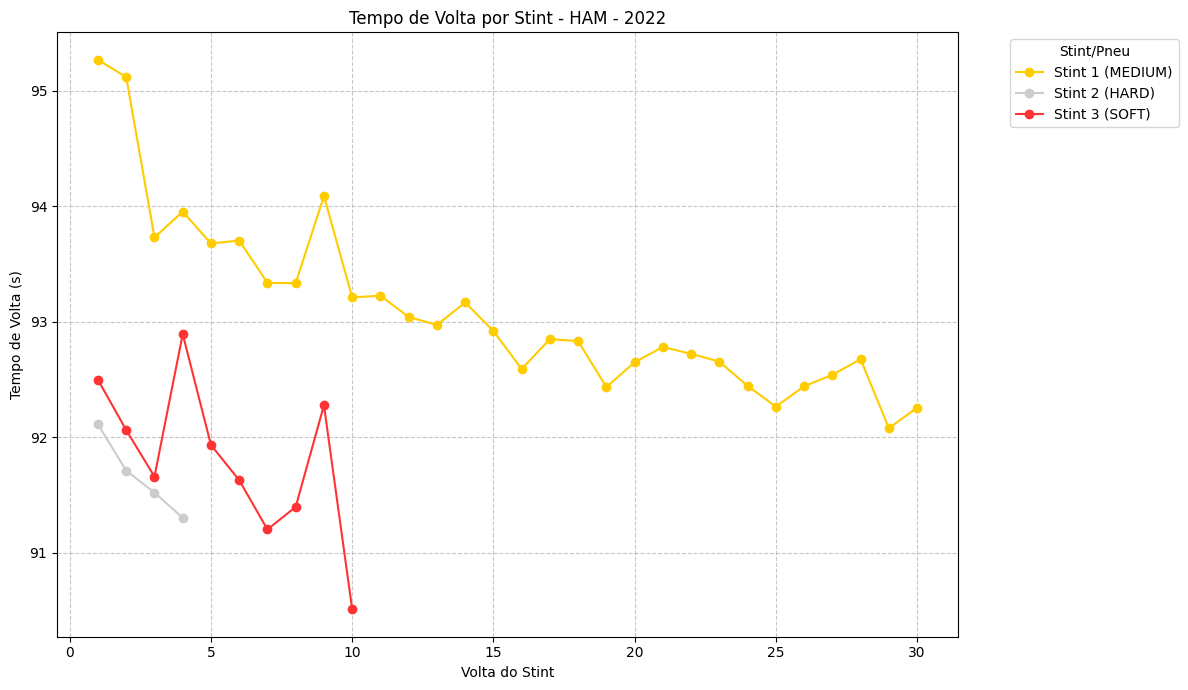

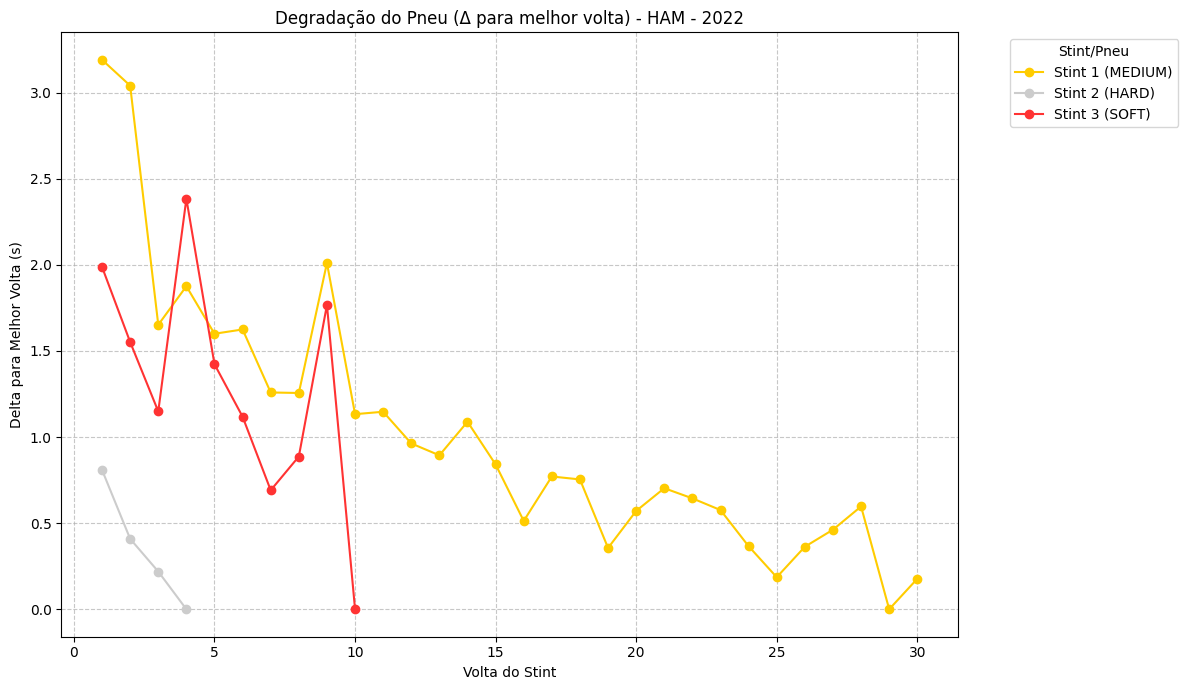

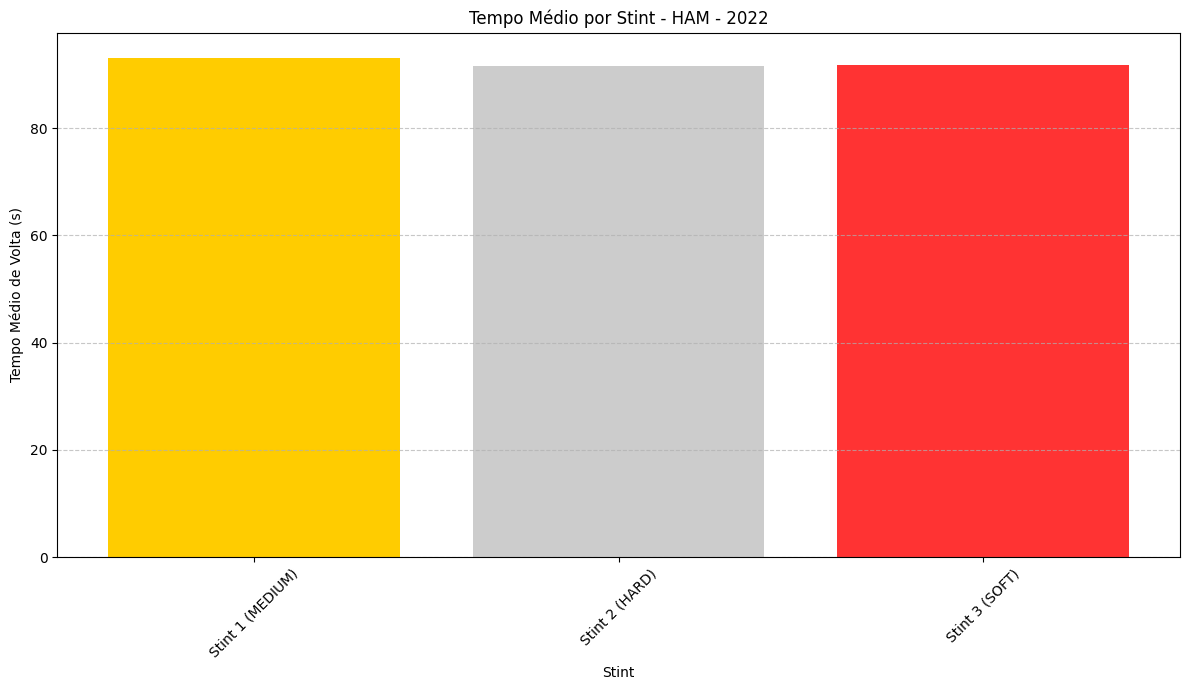

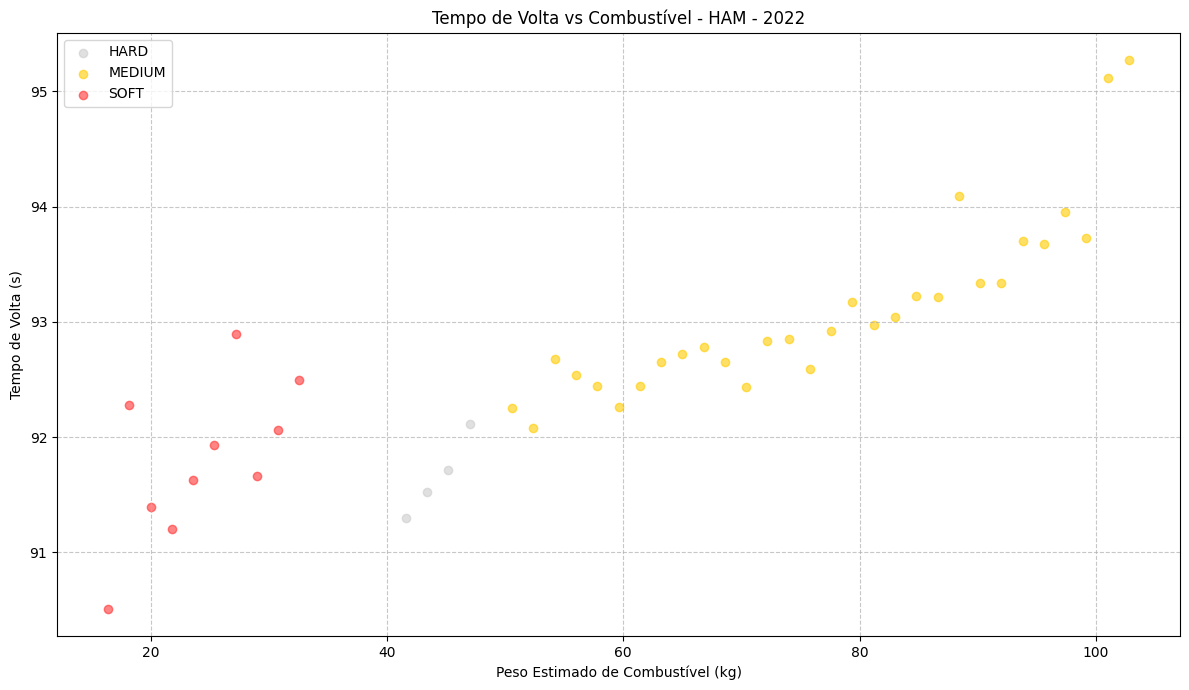

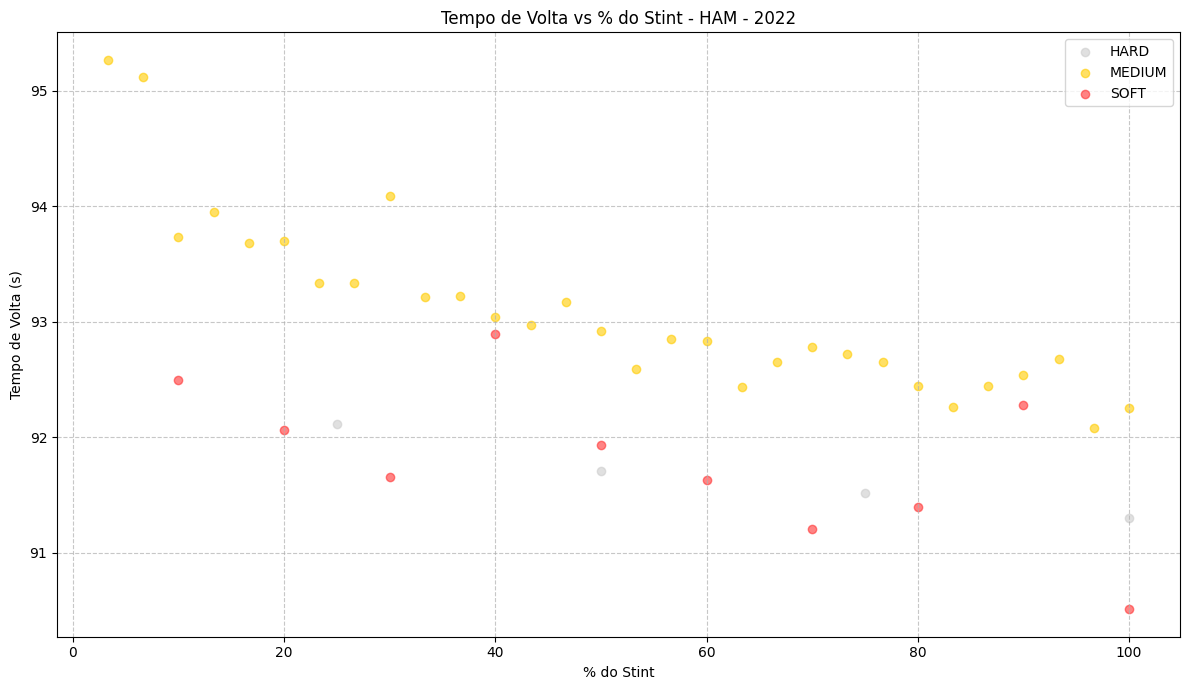


 Ano: 2023 | Voltas: 45


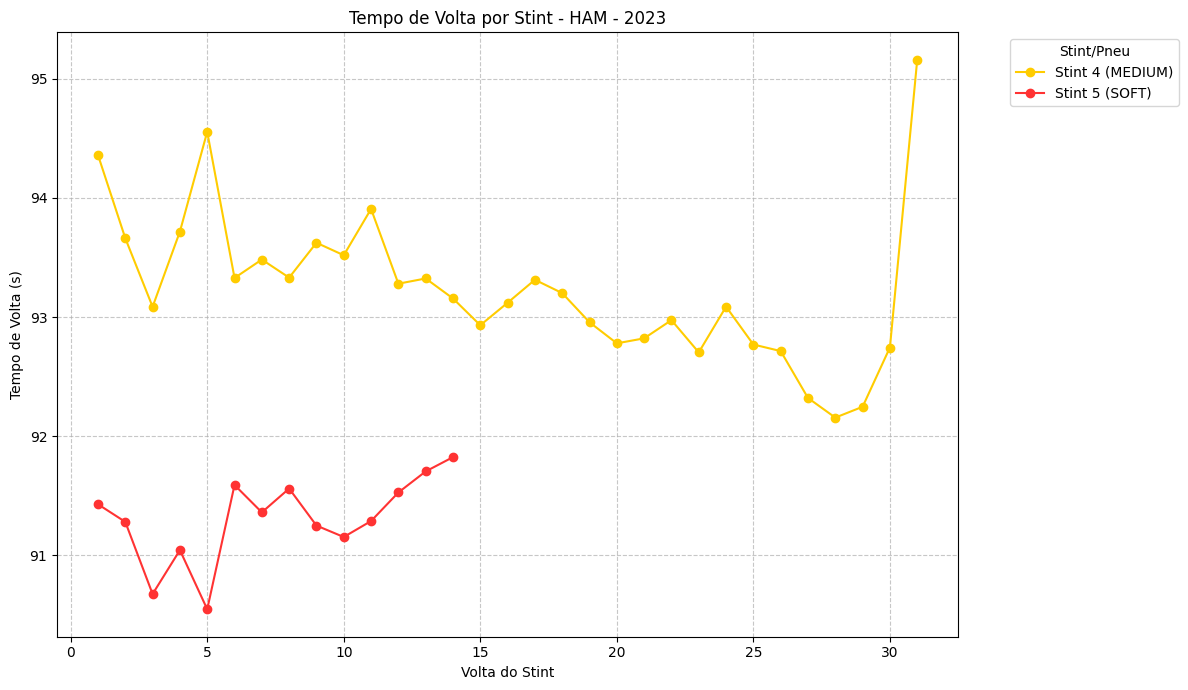

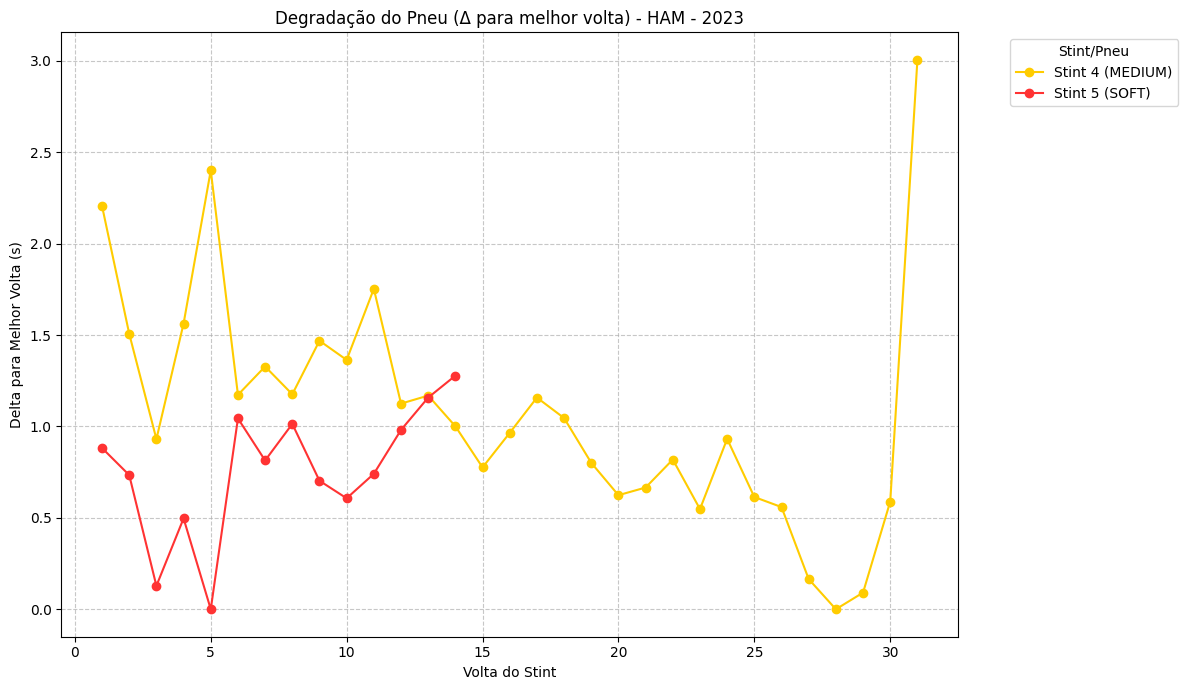

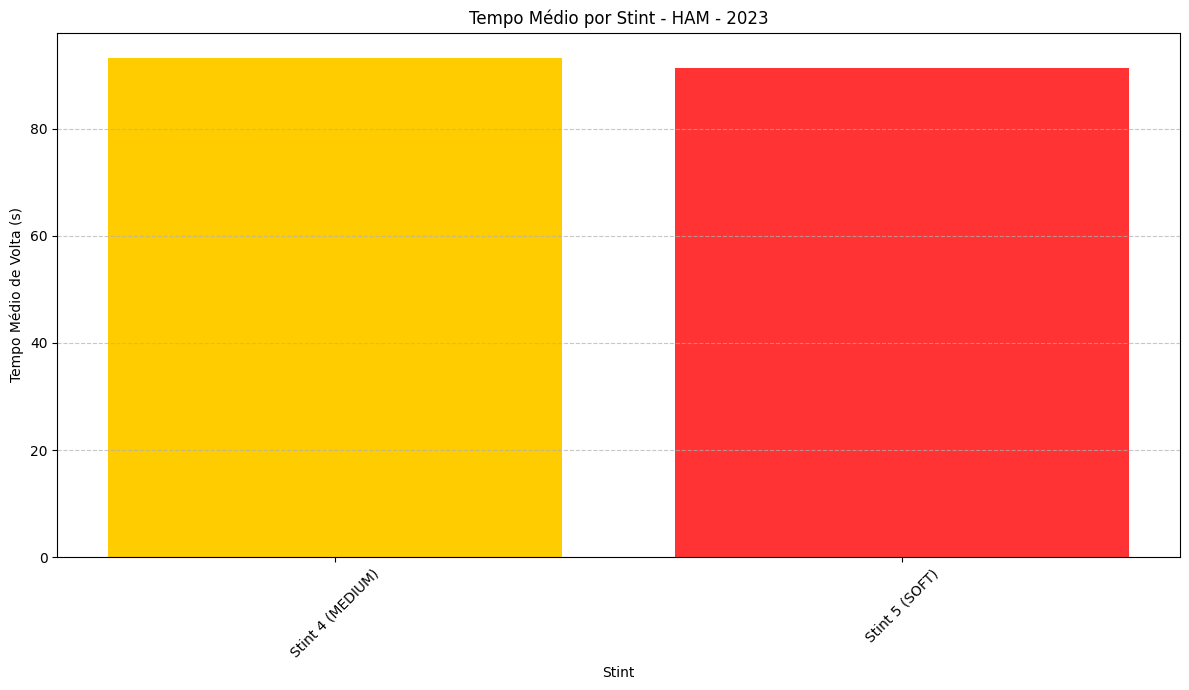

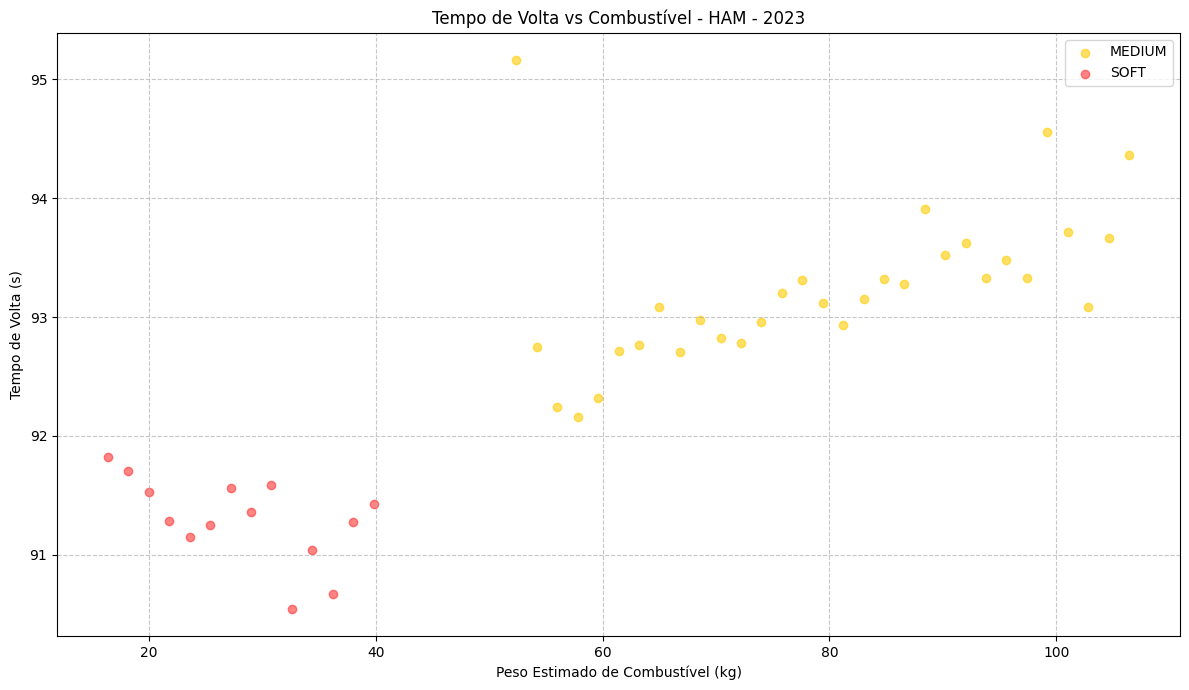

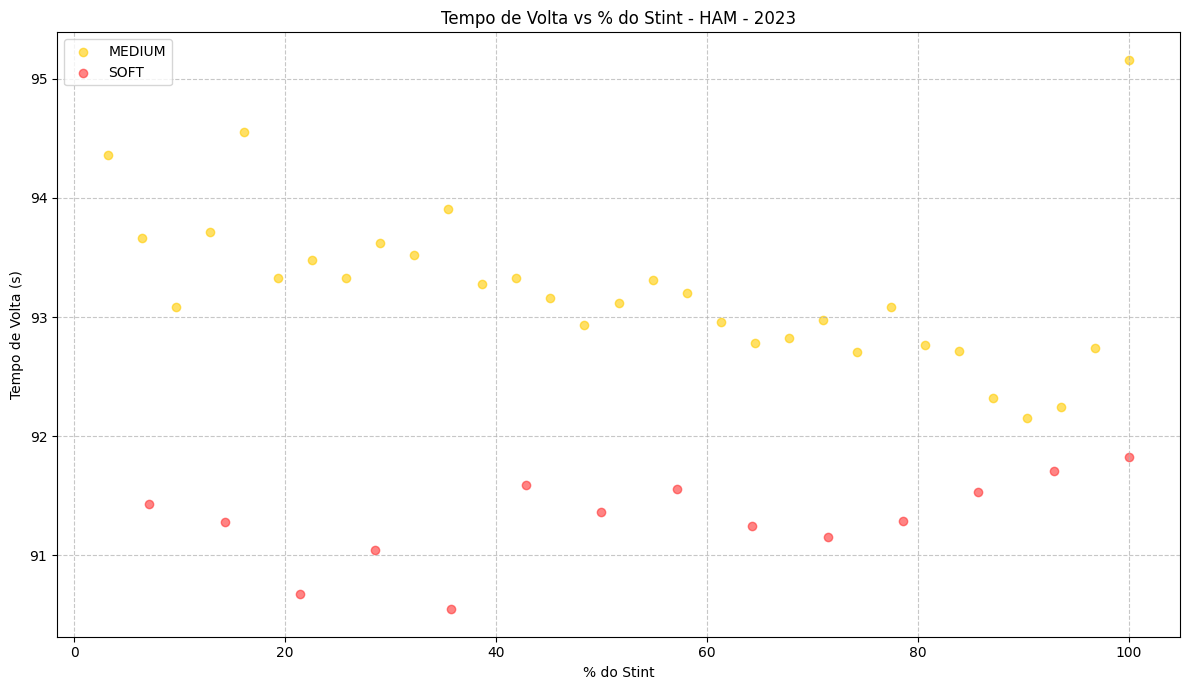


 Ano: 2024 | Voltas: 35


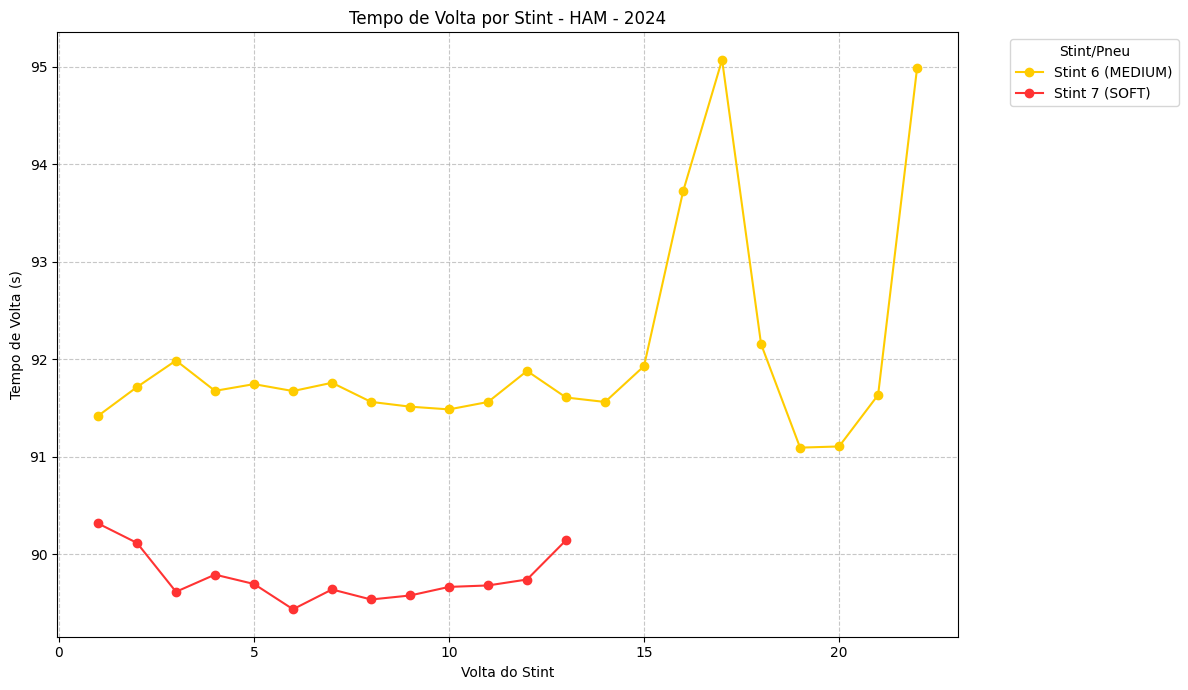

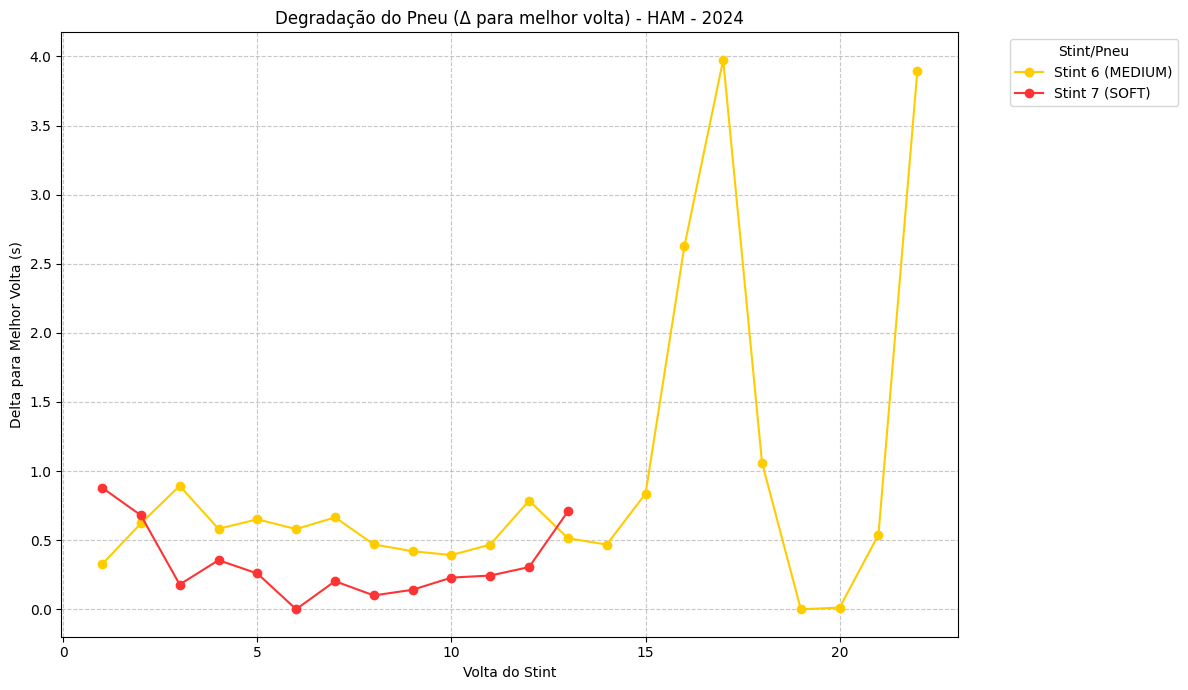

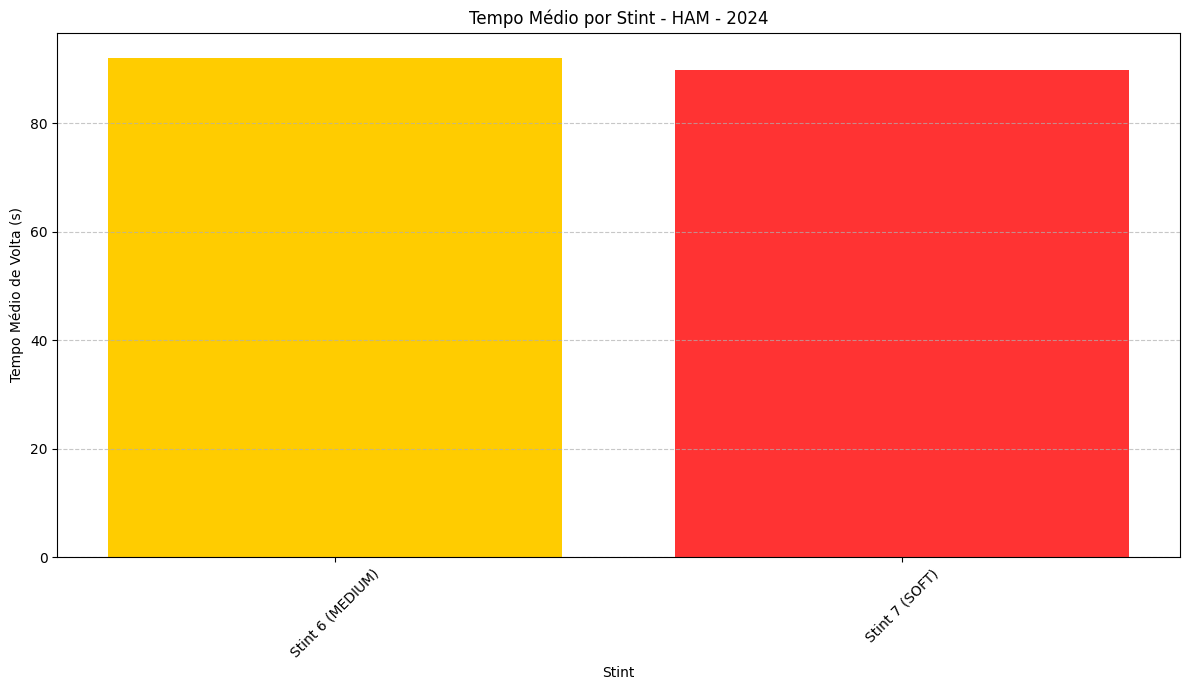

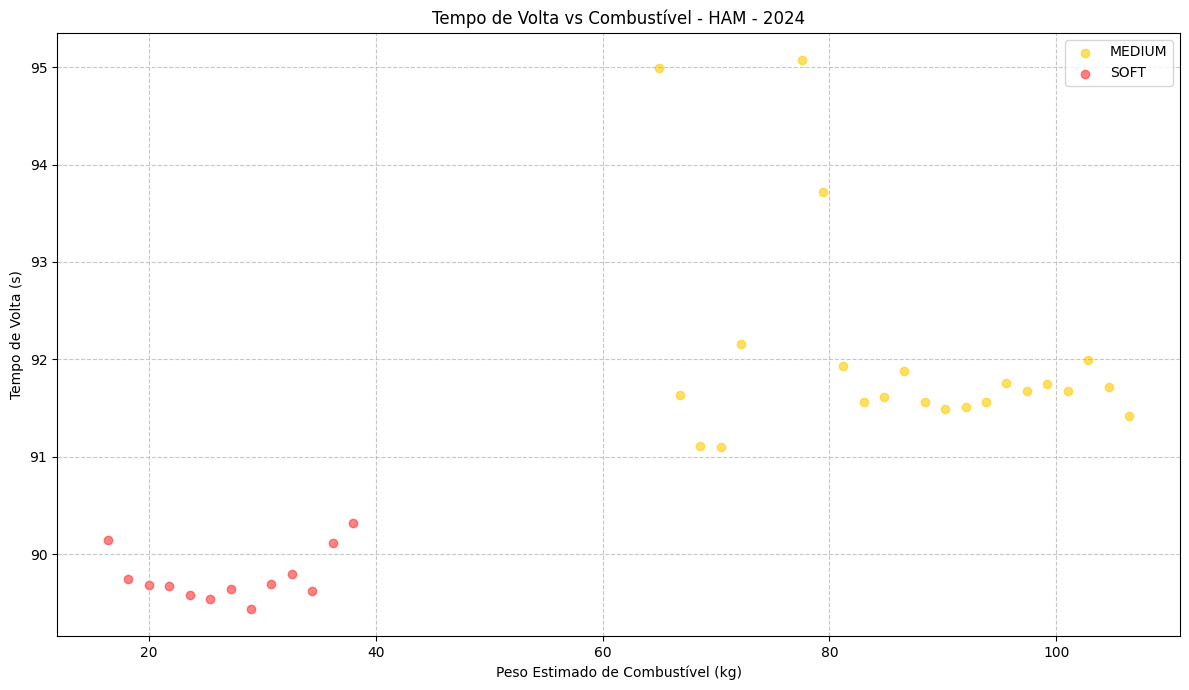

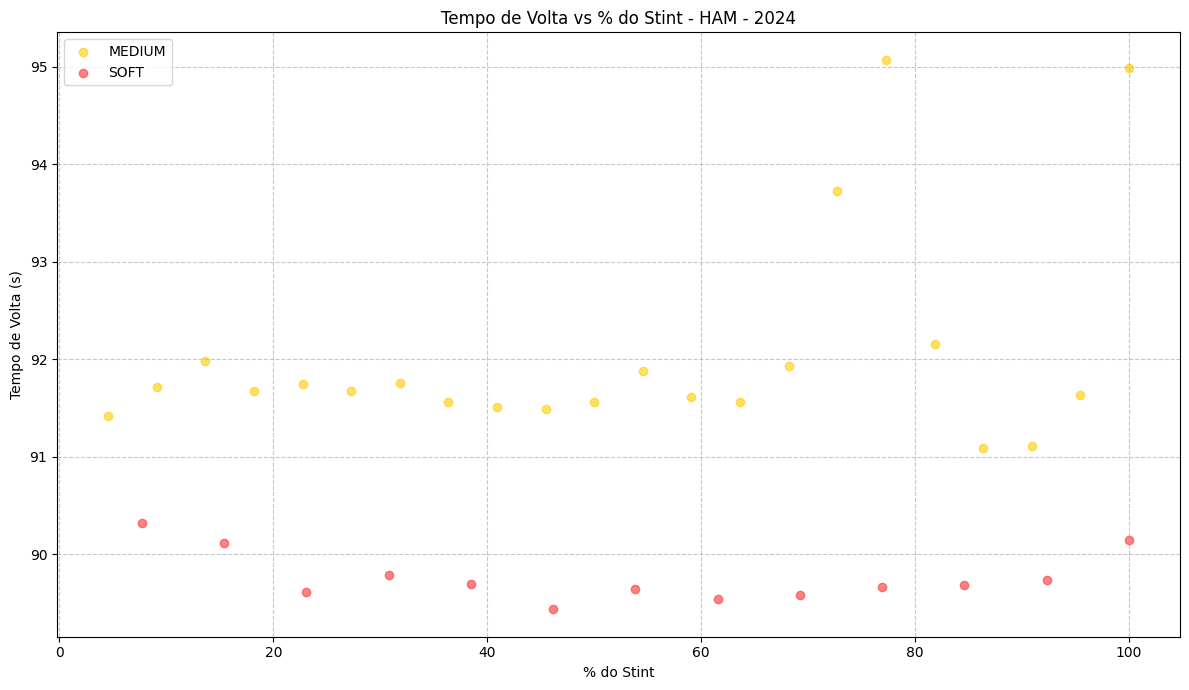


Visualização de análise de desgaste por ano concluída.


In [48]:
DATA_FILE = 'analyzed_fastf1_data_ALL_2022_2023_2024.csv'
DRIVER_TO_ANALYZE = 'HAM'

if os.path.exists(DATA_FILE):
    try:
        df_visual = pd.read_csv(DATA_FILE)
        print(f"\nCarregando dados para visualizações de desgaste: '{DATA_FILE}'.")
        driver_df_visual = df_visual[df_visual['drv'] == DRIVER_TO_ANALYZE].copy()

        if driver_df_visual.empty:
            print(f"Nenhum dado encontrado para o piloto '{DRIVER_TO_ANALYZE}' para visualização.")
            print(f"Pilotos disponíveis no dataset: {df_visual['drv'].unique().tolist()}")
        else:
            print(f"Dados filtrados para visualização do piloto: {DRIVER_TO_ANALYZE}. Total de {len(driver_df_visual)} voltas.")
            driver_df_visual['stint_group_id'] = (driver_df_visual['s_lap'] == 1).cumsum()

            compound_colors = {
                'SOFT': '#FF3333',
                'MEDIUM': '#FFCC00',
                'HARD': '#CCCCCC',
                'INTERMEDIATE': '#009900',
                'WET': '#0000FF',
                'UNKNOWN': '#800080',
                'TEST_UNKNOWN': '#808000'
            }

            for year in sorted(driver_df_visual['year'].unique()):
                df_year = driver_df_visual[driver_df_visual['year'] == year]

                print(f"\n Ano: {year} | Voltas: {len(df_year)}")

                # 1. Tempo de volta por stint
                plt.figure(figsize=(12, 7))
                for (stint_group_id, tyre), group in df_year.groupby(['stint_group_id', 'tyre']):
                    color = compound_colors.get(tyre, '#000000')
                    plt.plot(group['s_lap'], group['lap_time'], marker='o', linestyle='-', color=color,
                             label=f'Stint {stint_group_id} ({tyre})')
                plt.title(f'Tempo de Volta por Stint - {DRIVER_TO_ANALYZE} - {year}')
                plt.xlabel('Volta do Stint')
                plt.ylabel('Tempo de Volta (s)')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend(title='Stint/Pneu', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()

                # 2. Degradação (delta_best)
                plt.figure(figsize=(12, 7))
                for (stint_group_id, tyre), group in df_year.groupby(['stint_group_id', 'tyre']):
                    color = compound_colors.get(tyre, '#000000')
                    plt.plot(group['s_lap'], group['delta_best'], marker='o', linestyle='-', color=color,
                             label=f'Stint {stint_group_id} ({tyre})')
                plt.title(f'Degradação do Pneu (Δ para melhor volta) - {DRIVER_TO_ANALYZE} - {year}')
                plt.xlabel('Volta do Stint')
                plt.ylabel('Delta para Melhor Volta (s)')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend(title='Stint/Pneu', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()

                # 3. Tempo médio por stint
                plt.figure(figsize=(12, 7))
                stint_avg = df_year.groupby(['stint_group_id', 'tyre'])['lap_time'].mean().reset_index()
                stint_avg['label'] = stint_avg.apply(lambda row: f'Stint {row.stint_group_id} ({row.tyre})', axis=1)
                plt.bar(stint_avg['label'], stint_avg['lap_time'],
                        color=[compound_colors.get(c, '#000000') for c in stint_avg['tyre']])
                plt.title(f'Tempo Médio por Stint - {DRIVER_TO_ANALYZE} - {year}')
                plt.xlabel('Stint')
                plt.ylabel('Tempo Médio de Volta (s)')
                plt.xticks(rotation=45)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()

                # 4. Volta vs combustível
                plt.figure(figsize=(12, 7))
                for tyre, group in df_year.groupby('tyre'):
                    color = compound_colors.get(tyre, '#000000')
                    plt.scatter(group['fuel_kg'], group['lap_time'], alpha=0.6, label=tyre, color=color)
                plt.title(f'Tempo de Volta vs Combustível - {DRIVER_TO_ANALYZE} - {year}')
                plt.xlabel('Peso Estimado de Combustível (kg)')
                plt.ylabel('Tempo de Volta (s)')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend()
                plt.tight_layout()
                plt.show()

                # 5. Volta vs % do stint
                plt.figure(figsize=(12, 7))
                for tyre, group in df_year.groupby('tyre'):
                    color = compound_colors.get(tyre, '#000000')
                    plt.scatter(group['s_pct'] * 100, group['lap_time'], alpha=0.6, label=tyre, color=color)
                plt.title(f'Tempo de Volta vs % do Stint - {DRIVER_TO_ANALYZE} - {year}')
                plt.xlabel('% do Stint')
                plt.ylabel('Tempo de Volta (s)')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend()
                plt.tight_layout()
                plt.show()

            print("\nVisualização de análise de desgaste por ano concluída.")

    except Exception as e:
        logger.error(f"Erro ao carregar ou visualizar o arquivo CSV: {e}")
else:
    logger.error(f"Arquivo '{DATA_FILE}' não encontrado.")

In [47]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

CACHE_DIR = "./fastf1_cache"
YEARS = [2022, 2023, 2024]

def fill_outliers_with_median(df, col, n_std=2.5):
    df_copy = df.copy()
    
    df_copy['group_mean'] = df_copy.groupby(['drv', 'tyre'])[col].transform('mean')
    df_copy['group_std'] = df_copy.groupby(['drv', 'tyre'])[col].transform('std')
    
    df_copy['group_median'] = df_copy.groupby(['drv', 'tyre'])[col].transform('median')

    outlier_condition = (df_copy[col] > df_copy['group_mean'] + n_std * df_copy['group_std'])
    
    num_outliers_before = outlier_condition.sum()
    logger.info(f"Número de outliers identificados em '{col}': {num_outliers_before}")

    df_copy.loc[outlier_condition, col] = df_copy.loc[outlier_condition, 'group_median']
    
    df_filled = df_copy.drop(columns=['group_mean', 'group_std', 'group_median'])

    return df_filled

DATA_FILE = 'analyzed_fastf1_data_ALL_2022_2023_2024.csv'

if os.path.exists(DATA_FILE):
    try:
        df_raw = pd.read_csv(DATA_FILE)
        print(f"Dataset original carregado para tratamento de outliers (preenchimento): '{DATA_FILE}'. Shape: {df_raw.shape}")

        df_filled = fill_outliers_with_median(df_raw, 'lap_time', n_std=2.5)

        driver_tag = "ALL"
        filled_file_name = f"analyzed_fastf1_data_{driver_tag}_{'_'.join(map(str, YEARS))}_filled_outliers.csv"
        df_filled.to_csv(filled_file_name, index=False)
        logger.info("CSV com outliers preenchidos salvo como '%s' (%d linhas).", filled_file_name, len(df_filled))

        print(f"\n--- Resumo do Tratamento de Outliers (Preenchimento) ---")
        print(f"Número total de voltas no dataset: {len(df_raw)}")
        print(f"Número de voltas após o preenchimento: {len(df_filled)}") 

    except Exception as e:
        logger.error(f"Erro ao carregar ou processar o arquivo CSV para tratamento de outliers: {e}")
else:
    logger.error(f"Arquivo '{DATA_FILE}' não encontrado para tratamento de outliers. Por favor, execute a célula de geração de dados primeiro.")

INFO:__main__:Número de outliers identificados em 'lap_time': 28
INFO:__main__:CSV com outliers preenchidos salvo como 'analyzed_fastf1_data_ALL_2022_2023_2024_filled_outliers.csv' (2117 linhas).


Dataset original carregado para tratamento de outliers (preenchimento): 'analyzed_fastf1_data_ALL_2022_2023_2024.csv'. Shape: (2117, 30)

--- Resumo do Tratamento de Outliers (Preenchimento) ---
Número total de voltas no dataset: 2117
Número de voltas após o preenchimento: 2117
